In [2]:
%matplotlib inline

import sqlite3
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("final.sqlite not found")

In [4]:
#final.sample(frac=0.2)['Score'].value_counts()
positive_5k = final[final['Score'] == 1][:5000]
negative_5k = final[final['Score'] == 0][:5000]

final_df = pd.concat([positive_5k, negative_5k]).sample(frac=1)
print(positive_5k.shape)
print(negative_5k.shape)
print(final_df.shape)

(5000, 12)
(5000, 12)
(10000, 12)


In [5]:
final_df['Score'].value_counts()

1    5000
0    5000
Name: Score, dtype: int64

## Bag of Words

In [13]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_df['CleanedText'].values)

print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.shape)
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 14262)
the number of unique words  14262


In [14]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_counts.toarray())
print(standardized_data.shape)

(10000, 14262)


In [7]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, n_iter=2000, random_state=0)
tsne_data = model.fit_transform(standardized_data)

print(tsne_data.shape)

(10000, 2)


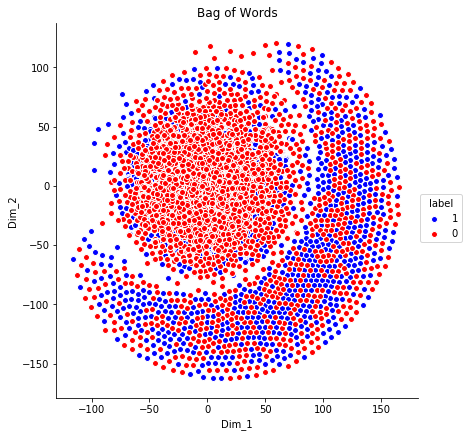

In [8]:
tsne_data_1 = np.vstack((tsne_data.T, final_df['Score'])).T
tsne_df = pd.DataFrame(tsne_data_1, columns=['Dim_1', 'Dim_2', 'label'])


sns.FacetGrid(tsne_df, hue='label', hue_order=[1, 0], palette={1:"blue", 0:"red"}, size=6).map(plt.scatter, 'Dim_1', 'Dim_2', edgecolor='w').add_legend()
plt.title('Bag of Words')
plt.show() 

## TF-IDF

In [9]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final_df['CleanedText'].values)
print(final_tf_idf.shape)

(10000, 14262)


In [10]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_tf_idf.toarray())
print(standardized_data.shape)

(10000, 14262)


In [11]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, n_iter=2000, random_state=0)
tsne_data = model.fit_transform(standardized_data)

print(tsne_data.shape)

(10000, 2)


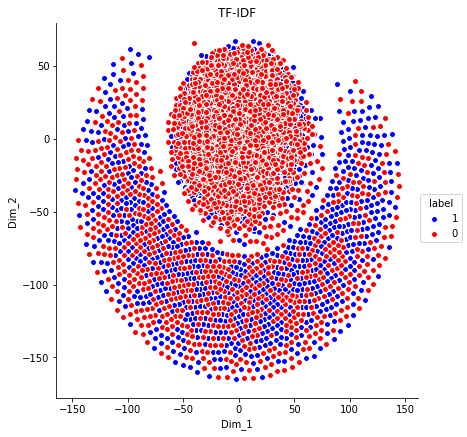

In [12]:
tsne_data_1 = np.vstack((tsne_data.T, final_df['Score'])).T
tsne_df = pd.DataFrame(tsne_data_1, columns=['Dim_1', 'Dim_2', 'label'])

sns.FacetGrid(tsne_df, hue='label', hue_order=[1, 0], palette={1:"blue", 0:"red"}, size=6).map(plt.scatter, 'Dim_1', 'Dim_2', edgecolor='w').add_legend()
plt.title('TF-IDF')
plt.show() 

## Word2Vec

In [13]:
list_of_sent=[]
for sent in final_df['CleanedText'].values:
    list_of_sent.append(sent.split())    

In [14]:
print(final_df['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

dec order dec confirm paid two day mail charg deliveri dec washington state dec still arriv
*****************************************************************
['dec', 'order', 'dec', 'confirm', 'paid', 'two', 'day', 'mail', 'charg', 'deliveri', 'dec', 'washington', 'state', 'dec', 'still', 'arriv']


In [15]:
w2v_model = Word2Vec(list_of_sent, min_count=5, size=50)

In [16]:
w2v_model.wv['tasti'].shape

(50,)

In [17]:
w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))

5070


## Avg Word2Vec

In [18]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 675.46it/s]


10000
50


In [19]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)
print(type(standardized_data))

(10000, 50)
<class 'numpy.ndarray'>


In [20]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, n_iter=2000, random_state=0)
tsne_data = model.fit_transform(standardized_data)

print(tsne_data.shape)

(10000, 2)


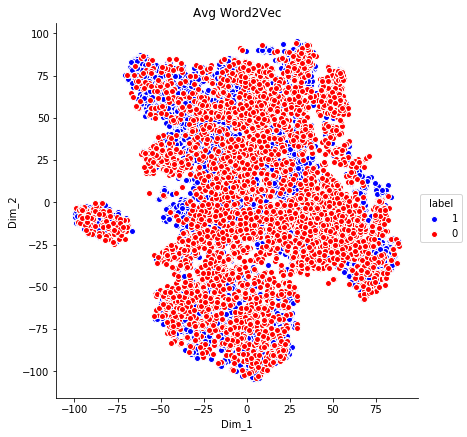

In [21]:
tsne_data_1 = np.vstack((tsne_data.T, final_df['Score'])).T
tsne_df = pd.DataFrame(tsne_data_1, columns=['Dim_1', 'Dim_2', 'label'])


sns.FacetGrid(tsne_df, hue='label', hue_order=[1, 0], palette={1:"blue", 0:"red"}, size=6).map(plt.scatter, 'Dim_1', 'Dim_2', edgecolor='w').add_legend()
plt.title('Avg Word2Vec')
plt.show() 

## TFIDF-W2V

In [22]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_df['CleanedText'].values)
# converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [23]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent):  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 576.34it/s]


In [24]:
len(sent_vectors)

10000

In [25]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)
print(type(standardized_data))

(10000, 50)
<class 'numpy.ndarray'>


In [26]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, n_iter=2000, random_state=0)
tsne_data = model.fit_transform(standardized_data)

print(tsne_data.shape)

(10000, 2)


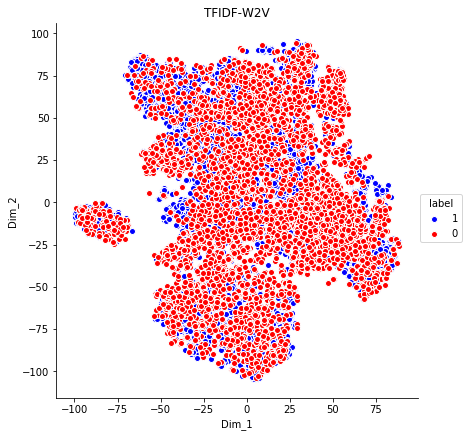

In [27]:
tsne_data_1 = np.vstack((tsne_data.T, final_df['Score'])).T
tsne_df = pd.DataFrame(tsne_data_1, columns=['Dim_1', 'Dim_2', 'label'])


sns.FacetGrid(tsne_df, hue='label', hue_order=[1, 0], palette={1:"blue", 0:"red"}, size=6).map(plt.scatter, 'Dim_1', 'Dim_2', edgecolor='w').add_legend()
plt.title('TFIDF-W2V')
plt.show() 